In [1]:
import matplotlib.pyplot as plt

import statsmodels.api as sm
import pandas as pd
import numpy as np

from statsmodels.tsa.stattools import coint
import warnings

from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)


def data_preprocess(dta):
    dta['Date'] = pd.to_datetime(dta['Date'], format='%Y-%m-%d')
    dta = dta.set_index(dta['Date'])
    # NHLI not traded
    dta.drop(['Date', 'NHLI'], axis=1, inplace=True)
    dta.dropna(how='all', inplace=True)
    for tick in dta.columns:
        tick_series = dta[tick]
        start_pos = tick_series.first_valid_index()
        valid_series = tick_series.loc[start_pos:]
        if valid_series.isna().sum() > 0:
            dta.drop(tick, axis=1, inplace=True)

    for tick in dta.columns:
        dta[tick] = dta[tick].mask(dta[tick] == 0).ffill(downcast='infer')

    return dta[dta.index >= dta['SPY'].first_valid_index()]


def coint_group(tick, dta):
    """
    Use cointegration test and correlation to find predictive stocks for target
    :param tick: string for the target stock
    :param dta: the data file (csv) that contains the tick
    :return: a list of tickers that are in sp500 which predict the target
    """
    dta['%s_LAG' % tick] = dta[tick].shift(-120)
    dta.dropna(inplace=True)

    y = dta['%s_LAG' % tick]
    cointegrat = {}
    correlat = {}

    for i in dta.columns[:-2]:
        x = dta[i]
        score, pval, _ = coint(x, y, trend='ct')
        corr = x.corr(y)

        cointegrat[i] = pval
        correlat[i] = corr

    best_coint = sorted(cointegrat, key=cointegrat.get)[:10]
    best_corr = sorted(correlat, key=correlat.get, reverse=True)[:10]

    intersect = list(set(best_coint) & set(best_corr))
    if len(intersect) > 0:
        print("There are {} cointegrated stocks.".format(len(intersect)))
        return intersect
    else:
        print("Intersection is empty.")
        return best_coint[:3]


def measure_profit(tick, fitted_val, asset, dta):
    inventory = 0
    asset = asset
    record = [asset]
    forecast_diff = fitted_val
    T = min(len(forecast_diff), len(dta))

    for t in range(T):
        trend_good = forecast_diff[t] > dta[tick].iloc[t]
        price = dta[tick].iloc[t]
        if trend_good and inventory == 0:
            # buy
            asset -= price
            inventory += 1
        elif not trend_good and inventory == 1:
            # sell
            asset += price
            inventory -= 1
        elif t == len(forecast_diff) - 1 and inventory == 1:
            asset += price
            inventory -= 1
        else:
            asset = record[-1]
        record.append(asset)

    return asset, record[1:]


def regression_mod(X, Y, dta):
    """
    Use basic regression model to forecast
    :param X: list of strings of tickers
    :param Y: string of lagged target ticker
    :param dta: the data set that contains X and Y
    :return: the regression model (statsmodels mod format)
    """
    X = dta[X]
    Y = dta[Y]
    mod = sm.OLS(Y, sm.add_constant(X)).fit()
    return mod


In [2]:
sp = pd.read_csv('sp500_stock_temp.csv')
data = pd.read_csv('broader_stock_temp.csv')

sp = data_preprocess(sp)
data = data_preprocess(data)

ticker_list = list(data.columns)
ticker_list.remove('SPY')

In [27]:
tick = 'NSP'

original_series = data[tick]

if tick in sp.columns:
    original_data = pd.concat([sp.drop([tick], axis=1), original_series], axis=1)
    original_data = original_data[original_data[tick].notnull()].dropna(axis=1)
else:
    original_data = pd.concat([sp, original_series], axis=1)
    original_data = original_data[original_data[tick].notnull()].dropna(axis=1)

observed_data = original_data.iloc[-5120:]

In [28]:
coint_corr = coint_group(tick, observed_data)

There are 1 cointegrated stocks.


In [29]:
reg_model = regression_mod(coint_corr, '%s_LAG' % tick, observed_data)
y_pred = reg_model.predict()

# examine trading profit
regasset, regrecord = measure_profit(tick, y_pred, 0, observed_data)

In [30]:
regasset

77.80999999999997

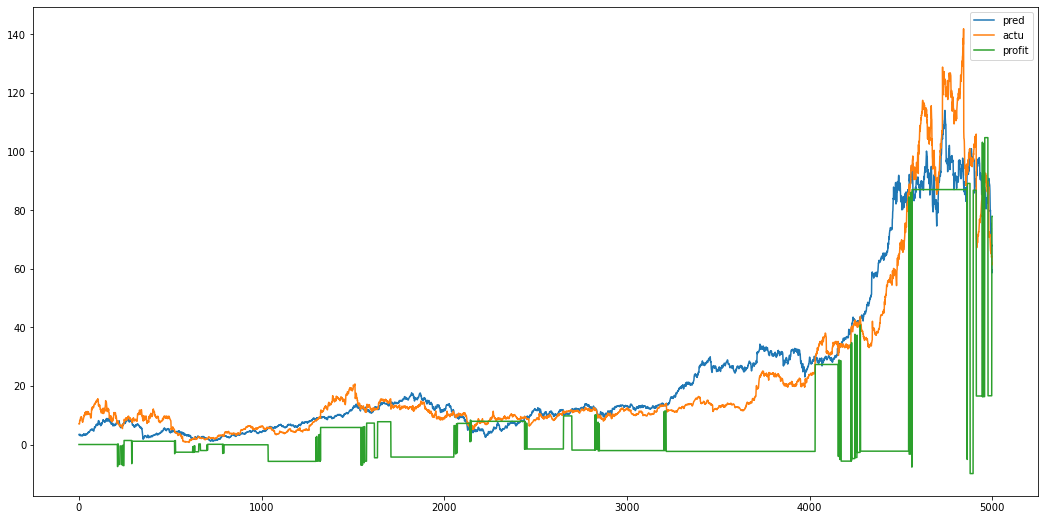

In [31]:
plt.figure(figsize=(18,9))
plt.plot(y_pred)
plt.plot(observed_data[tick].values)
plt.plot(regrecord)
plt.legend(['pred', 'actu', 'profit'])

In [32]:
latetest_data = sp[coint_corr]
reg_model.predict(sm.add_constant(latetest_data)).iloc[-1]

44.47425427655169

In [148]:


# machine learning model
train_length = 30
X, Y = [], []

for i in range(len(observed_data) - train_length):
    x = observed_data[coint_corr].iloc[i:i + train_length].values.T.flatten()
    y = observed_data['%s_LAG' % tick].iloc[i + train_length]
    X.append(x)
    Y.append(y)

X = np.array(X)
Y = np.array(Y).reshape(-1, 1)

print(X.shape, Y.shape)
mm_scaler_x = StandardScaler()
mm_scaler_y = StandardScaler()
lstm_mod = LSTM_mod(X, Y, mm_scaler_x, mm_scaler_y)

mm_scaler_x = mm_scaler_x.fit(X)
scale = mm_scaler_x.transform(X)
scale = scale.reshape(scale.shape[0], 1, scale.shape[1])

y_pred = lstm_mod.predict(scale)
mm_scaler_y = mm_scaler_y.fit(Y)
y_pred = mm_scaler_y.inverse_transform(y_pred)

# examine trading profit
mlasset, mlrecord = measure_profit(tick, y_pred.flatten(), 0, observed_data.shift(-train_length).iloc[:-train_length])

(5399, 120) (5399, 1)
Train on 3239 samples, validate on 2160 samples
Epoch 1/50
 - 1s - loss: 0.4285 - coeff_deter: 0.6205 - val_loss: 0.2862 - val_coeff_deter: 0.8589
Epoch 2/50
 - 0s - loss: 0.3777 - coeff_deter: 0.7042 - val_loss: 0.2608 - val_coeff_deter: 0.8686
Epoch 3/50
 - 1s - loss: 0.3568 - coeff_deter: 0.7366 - val_loss: 0.2927 - val_coeff_deter: 0.8511
Epoch 4/50
 - 0s - loss: 0.3452 - coeff_deter: 0.7564 - val_loss: 0.2808 - val_coeff_deter: 0.8687
Epoch 5/50
 - 0s - loss: 0.3371 - coeff_deter: 0.7584 - val_loss: 0.2312 - val_coeff_deter: 0.8987
Epoch 6/50
 - 0s - loss: 0.3269 - coeff_deter: 0.7798 - val_loss: 0.2300 - val_coeff_deter: 0.9051
Epoch 7/50
 - 0s - loss: 0.3297 - coeff_deter: 0.7774 - val_loss: 0.2125 - val_coeff_deter: 0.9089
Epoch 8/50
 - 0s - loss: 0.3244 - coeff_deter: 0.7835 - val_loss: 0.1965 - val_coeff_deter: 0.9186
Epoch 9/50
 - 1s - loss: 0.3229 - coeff_deter: 0.7825 - val_loss: 0.2784 - val_coeff_deter: 0.8693
Epoch 10/50
 - 0s - loss: 0.3203 - coef

In [149]:
mlasset

80.64

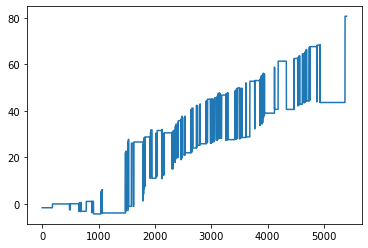

In [150]:
plt.plot(mlrecord)

In [151]:
test_data = original_data.iloc[cutoff:]
init_asset = 0
mlrecord_os = []

In [152]:
T = test_data.shape[0] // 120

In [153]:
for i in range(T):

    test_X = []

    for t in range(120):
        test_prep = original_data[coint_corr].iloc[(cutoff-30+t+i*120):(cutoff+t+i*120)].values.T.flatten()
        test_X.append(test_prep)

    test_X = np.array(test_X)
    scale_test_X = mm_scaler_x.transform(test_X)
    scale_test_X = scale_test_X.reshape(scale_test_X.shape[0], 1, scale_test_X.shape[1])

    y_pred_os = lstm_mod.predict(scale_test_X)
    y_pred_os = mm_scaler_y.inverse_transform(y_pred_os)

    init_asset, record = measure_profit(tick, y_pred_os, init_asset, test_data.iloc[i * 120:(i + 1) * 120])
    mlrecord_os += record

    # update model after record performance
    new_observed_data = original_data.iloc[i * 120:cutoff + (i + 1) * 120]
    coint_corr = coint_group(tick, new_observed_data)

    X, Y = [], []

    for t in range(len(new_observed_data) - train_length):
        x = new_observed_data[coint_corr].iloc[t:t + train_length].values.T.flatten()
        y = new_observed_data['%s_LAG' % tick].iloc[t + train_length]
        X.append(x)
        Y.append(y)

    X = np.array(X)
    Y = np.array(Y).reshape(-1, 1)

    mm_scaler_x = StandardScaler()
    mm_scaler_y = StandardScaler()
    lstm_mod = LSTM_mod(X, Y, mm_scaler_x, mm_scaler_y)

ated stocks.
Train on 3311 samples, validate on 2208 samples
Epoch 1/50
 - 1s - loss: 0.4268 - coeff_deter: 0.6155 - val_loss: 0.2724 - val_coeff_deter: 0.8516
Epoch 2/50
 - 1s - loss: 0.3776 - coeff_deter: 0.6916 - val_loss: 0.2890 - val_coeff_deter: 0.8467
Epoch 3/50
 - 1s - loss: 0.3500 - coeff_deter: 0.7392 - val_loss: 0.2457 - val_coeff_deter: 0.8848
Epoch 4/50
 - 1s - loss: 0.3423 - coeff_deter: 0.7470 - val_loss: 0.2134 - val_coeff_deter: 0.9087
Epoch 5/50
 - 1s - loss: 0.3271 - coeff_deter: 0.7720 - val_loss: 0.1910 - val_coeff_deter: 0.9244
Epoch 6/50
 - 1s - loss: 0.3180 - coeff_deter: 0.7849 - val_loss: 0.2126 - val_coeff_deter: 0.9100
Epoch 7/50
 - 1s - loss: 0.3279 - coeff_deter: 0.7610 - val_loss: 0.1978 - val_coeff_deter: 0.9233
Epoch 8/50
 - 1s - loss: 0.3191 - coeff_deter: 0.7804 - val_loss: 0.2202 - val_coeff_deter: 0.9074
Epoch 9/50
 - 1s - loss: 0.3183 - coeff_deter: 0.7746 - val_loss: 0.2319 - val_coeff_deter: 0.9053
Epoch 10/50
 - 0s - loss: 0.3093 - coeff_deter: 

In [154]:
test_X = []

for t in range(test_data.shape[0] % 120):
    test_prep = original_data[coint_corr].iloc[(cutoff-30+t+T*120):(cutoff+t+T*120)].values.T.flatten()
    test_X.append(test_prep)

test_X = np.array(test_X)
scale_test_X = mm_scaler_x.transform(test_X)
scale_test_X = scale_test_X.reshape(scale_test_X.shape[0], 1, scale_test_X.shape[1])

y_pred_os = lstm_mod.predict(scale_test_X)
y_pred_os = mm_scaler_y.inverse_transform(y_pred_os)

init_asset, record = measure_profit(tick, y_pred_os, init_asset, test_data.iloc[T * 120:])
mlrecord_os += record

In [157]:
init_asset

2.739999999999995

In [113]:
test = np.array([1,5,10,15, 100, 50, 100, 25, 86, 90])
test_scaler = MinMaxScaler()

def test_func(arr, scaler):
    scaler = scaler.fit(arr.reshape(-1,1))
    return scaler.transform(arr.reshape(-1,1))

In [114]:
test_func(test, test_scaler)

array([[0.        ],
       [0.04040404],
       [0.09090909],
       [0.14141414],
       [1.        ],
       [0.49494949],
       [1.        ],
       [0.24242424],
       [0.85858586],
       [0.8989899 ]])

In [115]:
test_scaler.transform(test.reshape(-1,1))

array([[0.        ],
       [0.04040404],
       [0.09090909],
       [0.14141414],
       [1.        ],
       [0.49494949],
       [1.        ],
       [0.24242424],
       [0.85858586],
       [0.8989899 ]])

In [2]:
result = pd.read_csv('Regression_Prediction_1.csv')

In [5]:
result.drop(['Unnamed: 0'], axis=1, inplace=True)

In [7]:
result = result.T

In [9]:
result.columns = ['in_profit', 'in_var', 'os_profit', 'os_var']

In [14]:
result['os/in profit'] = result['os_profit'] / result['in_profit']

In [16]:
result.sort_values(['os/in profit'], ascending=False).head(20)

,in_profit,in_var,os_profit,os_var,os/in profit
ZBH,19.20,0.248987,51.06,4.243600,2.659375
CLGX,39.04,0.023419,35.54,0.468477,0.910348
ROST,34.29,0.006816,30.41,0.938737,0.886847
GGG,20.77,0.002549,15.32,0.287751,0.737602
CBU,49.19,0.021785,36.23,0.414882,0.736532
APD,154.04,0.196917,111.95,4.757181,0.726759
ETR,64.19,0.081010,45.94,1.114922,0.715688
PRFT,23.82,0.009355,16.39,0.145097,0.688077
ADBE,134.69,0.199759,92.42,3.827720,0.686168
HPQ,22.31,0.007270,13.86,0.054593,0.621246
